# Fine Tuning Transformer for MultiLabel Text Classification

In [1]:
!pip install -q transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import KFold
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

import pandas as pd
import csv
from io import StringIO
import numpy as np
from PIL import Image
import zipfile
# from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import HistGradientBoostingClassifier
import plotly.express as px
import warnings
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
# import squarify
from nltk.corpus import wordnet
from nltk.corpus import stopwords

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [10]:
import zipfile

zip_path = '/content/drive/MyDrive/MBTI_NLP-20240415T214307Z-001.zip'

extract_to = '/content/drive/MyDrive/MBTI_NLP'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

csv_file_name = 'mbti_1.csv'

df = pd.read_csv(f'{extract_to}/{csv_file_name}')

df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [11]:
from sklearn.preprocessing import LabelEncoder
# use LabelEncoder to encode categorical labels to integers
encoder = LabelEncoder()
df['type'] = encoder.fit_transform(df['type'])


In [12]:
# Sections of config
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
# Ensuring target tensors are of type Long in the DataLoader setup
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.posts = dataframe['posts']
        self.targets = dataframe['type'].astype(int)
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        post = str(self.posts[index])
        post = " ".join(post.split())

        inputs = self.tokenizer.encode_plus(
            post,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs.get('token_type_ids', [0] * self.max_len)

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)  # Ensure targets are Long
        }


In [14]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (8675, 2)
TRAIN Dataset: (6940, 2)
TEST Dataset: (1735, 2)


In [ ]:
# train_params = {'batch_size': TRAIN_BATCH_SIZE,
#                 'shuffle': True,
#                 'num_workers': 0
#                 }

# test_params = {'batch_size': VALID_BATCH_SIZE,
#                 'shuffle': True,
#                 'num_workers': 0
#                 }

# training_loader = DataLoader(training_set, **train_params)
# testing_loader = DataLoader(testing_set, **test_params)



In [15]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 16)  # Assuming 16 classes

    def forward(self, ids, mask, token_type_ids):
        _, pooled_output = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        logits = self.classifier(dropout_output)
        return logits


model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [16]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

In [17]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [18]:
def train(epoch):
    model.train()
    for _, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.long)  # This must be float for BCEWithLogitsLoss

        outputs = model(ids, mask, token_type_ids)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        if _ % 5000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')


In [19]:
from torch.nn.utils.rnn import pad_sequence

def my_collate_fn(batch):
    ids = pad_sequence([item['ids'] for item in batch], batch_first=True, padding_value=0)
    masks = pad_sequence([item['mask'] for item in batch], batch_first=True, padding_value=0)
    token_type_ids = pad_sequence([item['token_type_ids'] for item in batch], batch_first=True, padding_value=0)
    targets = torch.stack([item['targets'] for item in batch])

    return {
        'ids': ids,
        'mask': masks,
        'token_type_ids': token_type_ids,
        'targets': targets
    }


train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                'collate_fn': my_collate_fn}

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **train_params)

In [ ]:
# for i in range(len(training_set)):
#     sample = training_set[i]  # This will call your __getitem__ and potentially show warnings if conversions are needed
#     if i > 10:  # Check the first 10 samples
#         break

In [ ]:
# calculation without the pipeline
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss: 3.0184199810028076


KeyboardInterrupt: 

In [ ]:
df

In [20]:
# calculation without the pipeline
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
# for epoch in range(EPOCHS):
#     outputs, targets = validation(epoch)
#     outputs = np.array(outputs) >= 0.5
#     accuracy = metrics.accuracy_score(targets, outputs)
#     f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
#     f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
#     print(f"Accuracy Score = {accuracy}")
#     print(f"F1 Score (Micro) = {f1_score_micro}")
#     print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
# calculate only accuracy and validation loss
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import accuracy_score

class NLPModelPipeline:
    def __init__(self, model, tokenizer, device):
        self.tokenizer = tokenizer
        self.model = model.to(device)
        self.device = device

    def preprocess_data(self, df):
        # Assuming CustomDataset is a class that appropriately handles the data preprocessing
        return CustomDataset(df, self.tokenizer, MAX_LEN)

    def train(self, train_loader, optimizer):
        self.model.train()
        total_loss = 0
        for _, data in enumerate(train_loader, 0):
            ids = data['ids'].to(self.device, dtype=torch.long)
            mask = data['mask'].to(self.device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(self.device, dtype=torch.long)
            targets = data['targets'].to(self.device, dtype=torch.long)

            outputs = self.model(ids, mask, token_type_ids)
            loss = torch.nn.CrossEntropyLoss()(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def evaluate(self, val_loader):
        self.model.eval()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for _, data in enumerate(val_loader, 0):
                ids = data['ids'].to(self.device, dtype=torch.long)
                mask = data['mask'].to(self.device, dtype=torch.long)
                token_type_ids = data['token_type_ids'].to(self.device, dtype=torch.long)
                targets = data['targets'].to(self.device, dtype=torch.long)

                outputs = self.model(ids, mask, token_type_ids)
                loss = torch.nn.CrossEntropyLoss()(outputs, targets)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                correct_predictions += (predicted == targets).sum().item()
                total_predictions += targets.size(0)

        accuracy = correct_predictions / total_predictions
        return total_loss / len(val_loader), accuracy

    def run(self, df, epochs=1, lr=1e-5, batch_size=8):
        processed_data = self.preprocess_data(df)
        results = []
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)

        for fold, (train_idx, val_idx) in enumerate(kfold.split(processed_data)):
            print(f"Running fold {fold + 1}")
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

            train_loader = DataLoader(processed_data, batch_size=batch_size, sampler=train_subsampler)
            val_loader = DataLoader(processed_data, batch_size=batch_size, sampler=val_subsampler)

            optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
            for epoch in range(epochs):
                train_loss = self.train(train_loader, optimizer)
                val_loss, val_accuracy = self.evaluate(val_loader)
                results.append((train_loss, val_loss, val_accuracy))
                print(f"Epoch {epoch}: Train Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

        return results

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClass()  # Assuming BERTClass is your model class
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pipeline = NLPModelPipeline(model=model, tokenizer=tokenizer, device=device)
# sample_df = df.sample(n=20)  # load your data into a DataFrame
final_results = pipeline.run(df)

Running fold 1
Epoch 0: Train Loss: 2.1977952563542926, Val Loss: 1.8380326507827653, Val Accuracy: 0.44726224783861673
Running fold 2
Epoch 0: Train Loss: 1.6370930902419552, Val Loss: 1.4173097518457245, Val Accuracy: 0.579250720461095
Running fold 3
Epoch 0: Train Loss: 1.352871043307166, Val Loss: 1.222883027132755, Val Accuracy: 0.6461095100864553
Running fold 4
Epoch 0: Train Loss: 1.1919911193408175, Val Loss: 1.0116676601328058, Val Accuracy: 0.7060518731988472
Running fold 5


In [21]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

class NLPModelPipeline:
    def __init__(self, model, tokenizer, device):
        self.tokenizer = tokenizer
        self.model = model.to(device)
        self.device = device

    def preprocess_data(self, df):
        return CustomDataset(df, self.tokenizer, MAX_LEN)

    def train(self, train_loader, optimizer):
        self.model.train()
        total_loss = 0
        for _, data in enumerate(train_loader):
            ids, mask, token_type_ids, targets = map(lambda x: x.to(self.device), (data['ids'], data['mask'], data['token_type_ids'], data['targets']))
            outputs = self.model(ids, mask, token_type_ids)
            loss = torch.nn.CrossEntropyLoss()(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def evaluate(self, val_loader):
      self.model.eval()
      total_loss = 0
      predictions, labels = [], []

      with torch.no_grad():
          for _, data in enumerate(val_loader):
              ids = data['ids'].to(self.device, dtype=torch.long)
              mask = data['mask'].to(self.device, dtype=torch.long)
              token_type_ids = data['token_type_ids'].to(self.device, dtype=torch.long)
              targets = data['targets'].to(self.device, dtype=torch.long)

              outputs = self.model(ids, mask, token_type_ids)
              loss = torch.nn.CrossEntropyLoss()(outputs, targets)
              total_loss += loss.item()

              _, predicted = torch.max(outputs, 1)
              predictions.extend(predicted.cpu().numpy())
              labels.extend(targets.cpu().numpy())

      return total_loss / len(val_loader), labels, predictions

    def run(self, df, epochs=1, lr=1e-5, batch_size=8, num_samples=None):
      processed_data = self.preprocess_data(df)
      kfold = KFold(n_splits=5, shuffle=True, random_state=42)
      all_folds_metrics = []
      last_epoch_data = []
      all_conf_matrices = []

      for fold, (train_idx, val_idx) in enumerate(kfold.split(processed_data)):
          print(f"Running fold {fold + 1}")
          train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
          val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

          train_loader = DataLoader(processed_data, batch_size=batch_size, sampler=train_subsampler)
          val_loader = DataLoader(processed_data, batch_size=batch_size, sampler=val_subsampler)

          optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
          fold_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

          for epoch in range(epochs):
              self.train(train_loader, optimizer)
              val_loss, y_test, y_pred = self.evaluate(val_loader)

              # Store metrics
              fold_metrics['accuracy'].append(accuracy_score(y_test, y_pred))
              fold_metrics['precision'].append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
              fold_metrics['recall'].append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
              fold_metrics['f1'].append(f1_score(y_test, y_pred, average='weighted', zero_division=0))

              if epoch == epochs - 1:  # Check if it's the last epoch
                  last_epoch_data.append((y_test, y_pred))
                  all_conf_matrices.append(last_epoch_data)

          all_folds_metrics.append(fold_metrics)
          average_conf_matrix = np.mean(all_conf_matrices, axis=0).astype(int)


      return all_folds_metrics, average_conf_matrix


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClass()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pipeline = NLPModelPipeline(model=model, tokenizer=tokenizer, device=device)
sample_df = df.sample(n=500).reset_index(drop=True)
sample_results, last_epoch_data = pipeline.run(df)


Running fold 1
Running fold 2
Running fold 3
Running fold 4
Running fold 5


In [22]:
sample_results[4]

{'accuracy': [0.715850144092219],
 'precision': [0.7441454649692727],
 'recall': [0.715850144092219],
 'f1': [0.7114172551038348]}

In [23]:
len(sample_results)

5

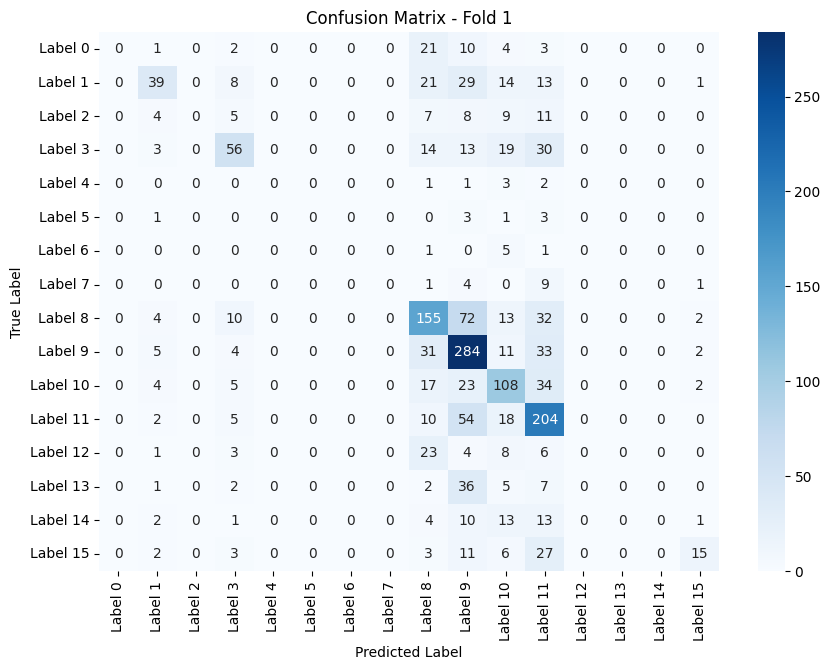

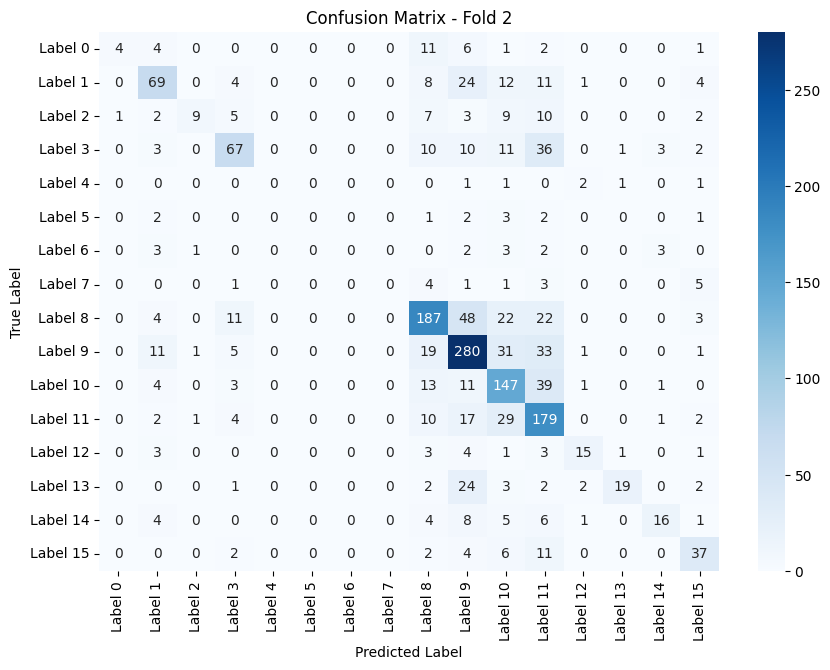

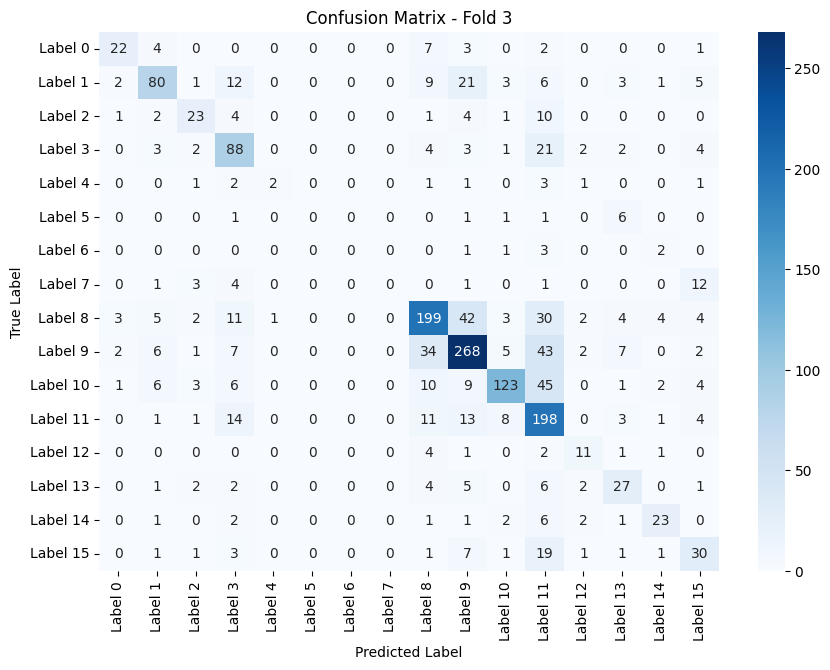

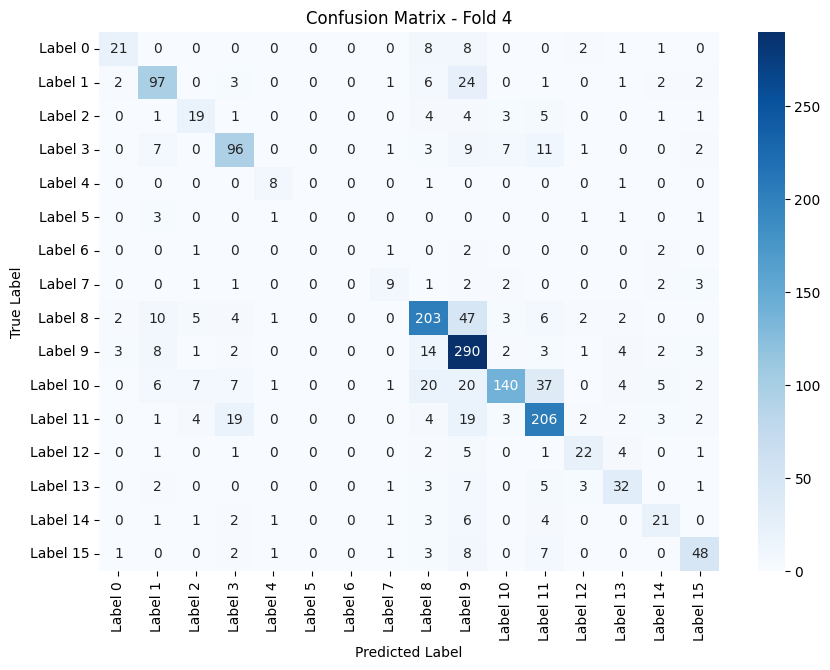

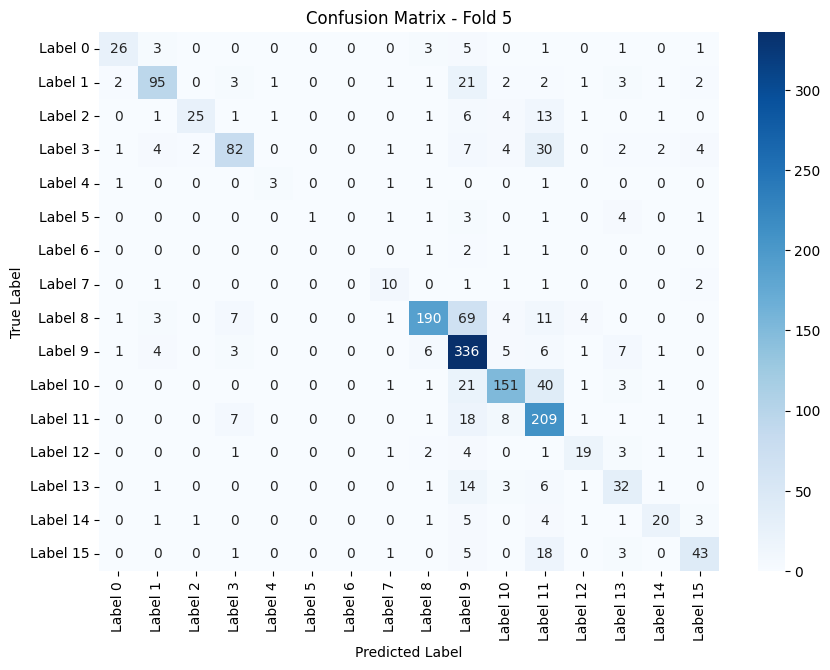

In [24]:
def plot_confusion_matrices(last_epoch_data):
    for i, (y_test, y_pred) in enumerate(last_epoch_data):
        conf_mat = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues', xticklabels=[f"Label {j}" for j in range(16)], yticklabels=[f"Label {j}" for j in range(16)])
        plt.title(f'Confusion Matrix - Fold {i+1}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

plot_confusion_matrices(last_epoch_data)


In [26]:
# Get the label mappings
label_mappings = {index: label for index, label in enumerate(encoder.classes_)}

# Print the mappings
print("Label mappings:")
for label_index, label_name in label_mappings.items():
    print(f"{label_index}: {label_name}")


Label mappings:
0: ENFJ
1: ENFP
2: ENTJ
3: ENTP
4: ESFJ
5: ESFP
6: ESTJ
7: ESTP
8: INFJ
9: INFP
10: INTJ
11: INTP
12: ISFJ
13: ISFP
14: ISTJ
15: ISTP


In [25]:
torch.cuda.empty_cache()